# Case Study Classification

Step 1 - Clean and prepare your data: 
There are several entries where values have been deleted to simulate dirty data. Please clean the data with whatever method(s) you believe is best/most suitable. Note that some of the missing values are truly blank (unknown answers). Success in this exercise typically involves feature engineering and avoiding data leakage.

In [1]:
%matplotlib inline
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.impute import KNNImputer
from scipy import stats
import seaborn as sns

In [2]:
# Import Data
data = pd.read_csv('/Users/thomasgow/Documents/IAA/Jobs/StateFarm/exercise_05_train.csv')
test = pd.read_csv('/Users/thomasgow/Documents/IAA/Jobs/StateFarm/exercise_05_test.csv')

In [3]:
data.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x91,x92,x93,x94,x95,x96,x97,x98,x99,y
0,0.963686,6.627185,-45.224008,9.477531,-3.216532,13.216874,9.754747,5.245851,-1.102918,-2.867482,...,0.988829,0.313772,asia,1.380664,-16.388994,5.326730,4.187294,0.045549,-3.646841,0
1,-1.770062,-23.610459,-0.964003,-31.981497,-10.294599,-10.240251,-1.518888,-1.675208,0.498134,-0.614390,...,-2.162863,1.809807,asia,2.500590,4.338834,-1.583225,-1.172417,0.011216,0.097180,0
2,9.962401,-8.349849,23.248891,-24.196879,8.937480,10.965000,-7.490596,-3.025094,0.595807,0.382732,...,1.779660,9.528113,asia,1.396475,7.839188,10.402396,1.288991,0.008209,-4.132316,0
3,-5.780709,-25.261584,1.383115,-11.786929,7.993078,-11.245752,-2.607351,-3.513896,-0.614235,-1.453979,...,-0.203206,4.892248,asia,0.744317,7.380982,7.599323,-8.022884,-0.067624,-1.796198,0
4,1.211541,1.119963,7.512938,21.987312,-5.155392,10.339416,3.045180,-0.619230,-0.928068,0.405024,...,0.248724,18.694990,asia,1.703196,-11.552129,0.381768,-3.550471,-0.055180,-3.344490,0


In [4]:
# Create mappers to clean categories
month_mapper = {'January':1,
                'Feb':2,
                'Mar':3,
                'Apr':4,
                'May':5,
                'Jun':6,
                'July':7,
                'Aug':8,
                'sept.':9,
                'Oct':10,
                'Nov':11,
                'Dev':12
               }

day_mapper = {'monday':1,
              'tuesday':2,
              'wed':3,
              'wednesday':3,
              'thurday':4,
              'thur':4,
              'tuesday':2,
              'friday':5,
              'fri':5
               }

In [5]:
def cleaning(df):
    """ Cleans the DataFrame """
    
    # Clean x41 and x45
    # Removes the $ from x41
    df.x41 = df.x41.str.replace('$', '').astype(float)

    # Turns x45 into decimal
    df.x45 = df.x45.str.replace('%', '').astype(float)
    df.x45 = df.x45/100

    # Turns categorical variables into number values
    df['x68'] = df['x68'].replace(month_mapper)
    df['x35'] = df['x35'].replace(day_mapper)

    # Changing the data type of the below mentioned columns and 
    change_cols=['x34', 'x35', 'x68', 'x93']

    #changing data type
    df[change_cols]=data[change_cols].astype('category')

    # Create codes for nominal variables
    df["x34"] = df["x34"].cat.codes
    df["x93"] = df["x93"].cat.codes

    # Turning -1's back into NA's for imputing
    df.loc[(df.x93 == -1),'x93']=np.nan
    df.loc[(df.x34 == -1),'x34']=np.nan
    
    return df

In [6]:
# Cleaning Datasets
data = cleaning(data)
test = cleaning(test)

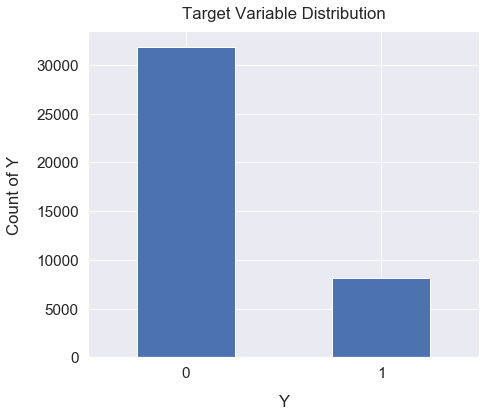

In [7]:
# Visual proportion of target variable
sns.set(font_scale=1.4)
data['y'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.xlabel("Y", labelpad=14)
plt.ylabel("Count of Y", labelpad=14)
plt.title("Target Variable Distribution", y=1.02);

In [8]:
# Check variables highly correlated with y
df_num = data.select_dtypes(include = ['float64', 'int64'])
df_num_corr = df_num.corr()['y'][:-1]
highest_corr = df_num_corr[abs(df_num_corr) > 0.5].sort_values(ascending=False)
print("There is {} strongly correlated values with y:\n{}".format(len(highest_corr), highest_corr))

There is 0 strongly correlated values with y:
Series([], Name: y, dtype: float64)


In [9]:
def impute(df):
    "Impute missing values"
    # Impute missing values 
    imputer = KNNImputer(n_neighbors=2, weights="uniform")
    imputed_df = imputer.fit_transform(df)
    imputed_df = pd.DataFrame(imputed_df)
    col_names = list(df.columns)
    imputed_df.columns = col_names
    
    # Round Imputed Categorical Data
    imputed_df['x34'] = imputed_df['x34'].round(decimals=0)
    imputed_df['x35'] = imputed_df['x35'].round(decimals=0)
    imputed_df['x68'] = imputed_df['x68'].round(decimals=0)
    imputed_df['x39'] = imputed_df['x93'].round(decimals=0)
    
    # Safegaurd values aren't more than max category
    imputed_df.loc[(imputed_df.x34 > 9),'x34']=9
    imputed_df.loc[(imputed_df.x35 > 5),'x35']=5
    imputed_df.loc[(imputed_df.x68 > 12),'x68']=12
    imputed_df.loc[(imputed_df.x93 > 2),'x93']=2
    
    # Return DF
    return imputed_df

In [10]:
# Creating train and test
def train_test(data):
    """Creates X_train, y_train, X_valid, y_valid"""
    rand_rows = np.random.rand(len(data)) < 0.6
    train = data[rand_rows]
    valid = data[~rand_rows]
    y_train = train['y']
    X_train = train.drop(['y'], axis=1)
    y_valid = valid['y']
    X_valid = valid.drop(['y'], axis=1)
    return y_train, X_train, y_valid, X_valid

y_train, X_train, y_valid, X_valid = train_test(data)

In [11]:
# Impute dataset
imputed_training = impute(X_train)
imputed_validation = impute(X_valid)
imputed_test = impute(test)

After looking into potentially removing outliers and scaling the variables I decided not to, because of potential data leakage.

In [12]:
# Looking into outliers
temp = imputed_training.copy()
print(len(temp))
temp = temp[(np.abs(stats.zscore(temp)) < 3).all(axis=1)]
print(len(temp))

23992
17924


Trying to limit data leakage I tried to minimally "clean" because if you perform feature selection on all of the data and then cross-validate then the test data fold was also used to choose the features and this may bias performance analysis. Also after running models 1-7 below, and seeing the high performance of the models I decided it was not worth the potential data leakage.

## Step 2 - Build your models: 
Task: Please use two different machine learning/statistical algorithms to develop a total of two models. Please include comments that document choices you make(such as those for feature engineering and for model tuning). 

I selected classification models to test on baseline models and picked the best two performing models. The two best performing models were CatBoostClassifier and LGBMClassifier. Also because 

In [22]:
# General
from time import time
import pprint

# Metrics
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix

# Skopt functions
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, VerboseCallback, DeltaXStopper
from skopt.space import Real, Categorical, Integer

# Models
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold

In [14]:
# Creating empty list
classifiers = []

# Model 1 XGBClassifier
model1 = XGBClassifier()
classifiers.append(model1)

# Model 2 SVC
model2 = SVC()
classifiers.append(model2)

# Model 3 DecisionTreeClassifier
model3 = DecisionTreeClassifier()
classifiers.append(model3)

# Model 4 RandomForestClassifier
model4 = RandomForestClassifier()
classifiers.append(model4)

# Model 5 GaussianNB
model5 = GaussianNB()
classifiers.append(model5)

# Model 6 CatBoostClassifier
model6 = CatBoostClassifier(verbose=False)
classifiers.append(model6)

# Model 7 LGBMClassifier
model7 = LGBMClassifier()
classifiers.append(model7)

In [15]:
# Loop for training the basic models
for clf in classifiers:
    start = time()
    clf.fit(imputed_training, y_train)
    stop = time()
    y_pred= clf.predict(imputed_validation)
    acc = accuracy_score(y_valid, y_pred)
    duration = stop-start
    print("%s \n Accuracy: %s \n Duration: %s"%(clf, acc, duration))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1) 
 Accuracy: 0.9012368815592204 
 Duration: 22.660205125808716
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False) 
 Accuracy: 0.8481384307846077 
 Duration: 28.23619818687439
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
   

#### CatBoost
Besides performing as one of the best of the tested classification models, CatBoost creates better results with less data and less tuning compared to other models, has fast computation, and its impressive handling of categorical features.

In [16]:
# Create random seed
seed = 67

# Setting categorical
categorical_names = ['x34', 'x35', 'x68', 'x93']
categoricals = [imputed_training.columns.get_loc(i) for i in categorical_names]
df_names = [imputed_training, imputed_validation, imputed_test]
print(categoricals)

[34, 35, 68, 93]


In [17]:
# Formatting category columns
for i in df_names:
    for ii in categorical_names:
        i[ii] = i[ii].astype('int')

In [114]:
# Performance Optimization Function
def opt_performance(optimizer, X, y, title, callbacks=None):
    """
    To fit and capture the performance and time. Meant to be used with Catboost and Lightgbm.
    
    optimizer = skopt optimizer
    X = the training set 
    y = our target
    title = a string label for the experiment
    
    best_params: outputs best performing parameter models
    """
    start = time()
    if callbacks:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)
    optimizer.fit(X, y)
    results = pd.DataFrame(optimizer.cv_results_)
    best_score = optimizer.best_score_
    best_score_std = results.iloc[optimizer.best_index_].std_test_score
    best_params = optimizer.best_params_
    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           +u"\u00B1"+" %.3f") % (time() - start, 
                                  len(optimizer.cv_results_['params']),
                                  best_score,
                                  best_score_std))    
    print('Best parameters:')
    pprint.pprint(best_params)
    print()
    return best_params

In [115]:
# Create scorer for AUC
roc_auc = make_scorer(roc_auc_score, greater_is_better=True, needs_threshold=True)


skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)

In [116]:
clf_cat = CatBoostClassifier(thread_count=2,
                         loss_function='Logloss',
                         od_type = 'Iter',
                         verbose= False,
                         cat_features=categoricals
                        )

In [117]:
# Defining your search space
space4catboost = {'iterations': Integer(100, 1000),
                 'depth': Integer(5, 10),
                 'learning_rate': Real(0.01, 0.5, 'log-uniform'),
                 'random_strength': Real(1e-9, 10, 'log-uniform'),
                 'bagging_temperature': Real(0.0, 1.0),
                 'border_count': Integer(32, 255),
                 'l2_leaf_reg': Integer(2, 5),
                 'scale_pos_weight':Real(0.01, 1.0, 'uniform')}


In [118]:
# Setting up BayesSearchCV
opt_cat = BayesSearchCV(clf_cat,
                    space4catboost,
                    scoring=roc_auc,
                    cv=skf,
                    n_iter=100,
                    n_jobs=1,  # use just 1 job with CatBoost in order to avoid segmentation fault
                    return_train_score=False,
                    refit=True,
                    optimizer_kwargs={'base_estimator': 'GP'},
                    random_state=seed)

In [121]:
best_params_cat = opt_performance(opt_cat, imputed_training, y_train,'CatBoost',
                                       callbacks=[DeltaXStopper(0.001),
                                                  DeadlineStopper(100*5)])

CatBoost took 15368.61 seconds,  candidates checked: 100, best CV score: 0.989 ± 0.002
Best parameters:
OrderedDict([('bagging_temperature', 0.0),
             ('border_count', 255),
             ('depth', 9),
             ('iterations', 1000),
             ('l2_leaf_reg', 5),
             ('learning_rate', 0.1825499244262304),
             ('random_strength', 1e-09),
             ('scale_pos_weight', 1.0)])



In [122]:
%%time
tuned_model_cat = CatBoostClassifier(**best_params_cat,od_type='Iter',one_hot_max_size=10, verbose=False, random_seed=seed)
tuned_model_cat.fit(imputed_training,y_train, cat_features=categoricals)

CPU times: user 7min 11s, sys: 48.2 s, total: 8min
Wall time: 1min 17s


In [123]:
%%time
y_pred_cat = tuned_model_cat.predict_proba(imputed_validation)[:, 1]
valid_score_cat = roc_auc_score(y_valid, y_pred_cat)
print('Validation ROC-AUC score:', valid_score_cat)
##ROC_AUC is 0.9880908960669734

Validation ROC-AUC score: 0.9875851857059373
CPU times: user 157 ms, sys: 92.7 ms, total: 250 ms
Wall time: 139 ms


In [124]:
%%time
tuned_model_cat = CatBoostClassifier(**best_params_cat,od_type='Iter',one_hot_max_size=10,verbose=False, random_seed=seed)
tuned_model_cat.fit(imputed_training,y_train, cat_features=categoricals)
pprint.pprint(best_params_cat)

OrderedDict([('bagging_temperature', 0.0),
             ('border_count', 255),
             ('depth', 9),
             ('iterations', 1000),
             ('l2_leaf_reg', 5),
             ('learning_rate', 0.1825499244262304),
             ('random_strength', 1e-09),
             ('scale_pos_weight', 1.0)])
CPU times: user 7min 22s, sys: 50.9 s, total: 8min 13s
Wall time: 1min 18s


In [145]:
cat_best_params = {'iterations': 1000,
                   'depth': 9,
                   'learning_rate': 0.1825499244262304,
                   'random_strength': 1e-9,
                   'bagging_temperature': 0,
                   'border_count': 255,
                   'l2_leaf_reg': 5,
                   'scale_pos_weight': 1}

In [125]:
roc_auc = make_scorer(roc_auc_score, greater_is_better=True, needs_threshold=True)
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)

In [126]:
clf_lgbm = LGBMClassifier(thread_count=2,
                          loss_function='Logloss',
                          od_type = 'Iter',
                          verbose=0
                        )

In [127]:
# Defining your search space
space4lightgbm = {'num_leaves': Integer(10, 50),
                  'max_depth': Integer(5, 10),
                  'learning_rate': Real(0.01, 0.5, 'log-uniform'),
                  'lambda_l2': Real(0.0001, 5.0, 'log-uniform'),
                  'min_child_samples': Integer(0, 200),
                  'min_child_weight': Integer(0, 10)}


In [128]:
# Setting up BayesSearchCV
opt_lightgbm = BayesSearchCV(clf_lgbm,
                             space4lightgbm,
                             scoring=roc_auc,
                             cv=skf,
                             n_iter=100,
                             n_jobs=1,
                             return_train_score=False,
                             refit=True,
                             optimizer_kwargs={'base_estimator': 'GP'},
                             random_state=seed,
                             verbose=False)

In [129]:
best_params_lightgbm = opt_performance(opt_lightgbm, imputed_training, y_train,'LightGBM',
                                       callbacks=[DeltaXStopper(0.0001),
                                                  DeadlineStopper(100*5)]);

LightGBM took 919.22 seconds,  candidates checked: 100, best CV score: 0.987 ± 0.001
Best parameters:
OrderedDict([('lambda_l2', 0.0001),
             ('learning_rate', 0.2673475162170724),
             ('max_depth', 10),
             ('min_child_samples', 200),
             ('min_child_weight', 0),
             ('num_leaves', 40)])



In [130]:
%%time
tuned_model_lgbm = LGBMClassifier(**best_params_lightgbm,od_type='Iter',one_hot_max_size=10, verbose=0, random_seed=seed)
tuned_model_lgbm.fit(imputed_training,y_train)

CPU times: user 8.25 s, sys: 319 ms, total: 8.57 s
Wall time: 1.13 s


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', lambda_l2=0.0001,
               learning_rate=0.2673475162170724, max_depth=10,
               min_child_samples=200, min_child_weight=0, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=40, objective=None,
               od_type='Iter', one_hot_max_size=10, random_seed=67,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
               verbose=0)

In [131]:
%%time
y_pred_lgbm = tuned_model_lgbm.predict_proba(imputed_validation)[:, 1]
valid_score_lgbm = roc_auc_score(y_valid, y_pred_lgbm)
print('Validation ROC-AUC score:', valid_score_lgbm)
##ROC_AUC is 0.8056

Validation ROC-AUC score: 0.9844737806952922
CPU times: user 939 ms, sys: 109 ms, total: 1.05 s
Wall time: 144 ms


In [132]:
# Comparing the two models
print('Validation CAT ROC-AUC score:', valid_score_cat)
print('Validation LGBM ROC-AUC score:', valid_score_lgbm)

Validation CAT ROC-AUC score: 0.9875851857059373
Validation LGBM ROC-AUC score: 0.9844737806952922


In [133]:
%%time
tuned_model_lgbm = LGBMClassifier(**best_params_lightgbm,od_type='Iter',one_hot_max_size=10, verbose=0, random_seed=seed)
tuned_model_lgbm.fit(imputed_training,y_train)

CPU times: user 8.27 s, sys: 231 ms, total: 8.5 s
Wall time: 1.1 s


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', lambda_l2=0.0001,
               learning_rate=0.2673475162170724, max_depth=10,
               min_child_samples=200, min_child_weight=0, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=40, objective=None,
               od_type='Iter', one_hot_max_size=10, random_seed=67,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
               verbose=0)

In [146]:
# Final LightGBM

best_params_lightgbm = {'num_leaves': 40,
                        'max_depth': 10,
                        'learning_rate': 0.2673475162170724,
                        'lambda_l2': 0.0001,
                        'num_iterations': 200,
                        'min_child_samples': 200,
                        'min_child_weight': 0}


In [137]:
# Predict using two models
y_pred_lgbm = tuned_model_lgbm.predict(imputed_validation)
y_pred_catboost = tuned_model_cat.predict(imputed_validation)

# Score validation
lgbm_validation = roc_auc_score(y_valid, y_pred_lgbm)
catboost_validation = roc_auc_score(y_valid, y_pred_catboost)

In [138]:
# Comparing the two models
print('Test Score LGBM ROC-AUC score:', lgbm_validation)
print('Test Score CAT ROC-AUC score:', catboost_validation)

Test Score LGBM ROC-AUC score: 0.9415704780358917
Test Score CAT ROC-AUC score: 0.9540364074150559


In [139]:
# Metrics
print('LGBM Accuracy score: ', accuracy_score(y_valid, y_pred_lgbm))
print('CAT Accuracy score: ', accuracy_score(y_valid, y_pred_catboost))

print('LGBM Precision score: ', precision_score(y_valid, y_pred_lgbm))
print('CAT Precision score: ', precision_score(y_valid, y_pred_catboost))

print('LGBM Recall score: ', recall_score(y_valid, y_pred_lgbm))
print('CAT Recall score: ', recall_score(y_valid, y_pred_catboost))

print('LGBM AUC score: ', roc_auc_score(y_valid, y_pred_lgbm))
print('CAT AUC score: ', roc_auc_score(y_valid, y_pred_catboost))

print('LGBM Confusion Matrix: ')
pprint.pprint(confusion_matrix(y_valid, y_pred_lgbm))
print('LGBM Confusion Matrix: ')
pprint.pprint(confusion_matrix(y_valid, y_pred_catboost))

LGBM Accuracy score:  0.9720139930034982
CAT Accuracy score:  0.9793853073463268
LGBM Precision score:  0.9664179104477612
CAT Precision score:  0.9838056680161943
LGBM Recall score:  0.8908692933083177
CAT Recall score:  0.9118198874296435
LGBM AUC score:  0.9415704780358917
CAT AUC score:  0.9540364074150559
LGBM Confusion Matrix: 
array([[12711,    99],
       [  349,  2849]])
LGBM Confusion Matrix: 
array([[12762,    48],
       [  282,  2916]])


In [140]:
#Make predictions using the features from the test data set
predictions_lgbm = tuned_model_lgbm.predict(imputed_test)
predictions_cat = tuned_model_cat.predict(imputed_test)


#Display our predictions - they are either 0 or 1 for each training instance 
#depending on whether our algorithm believes the person survived or not.
predictions_lgbm

array([0, 0, 0, ..., 0, 1, 0])

In [143]:
#Create a  DataFrame with the passengers ids and our prediction regarding whether they survived or not
file1 = pd.DataFrame({'Predicted':predictions_lgbm})
file2 = pd.DataFrame({'Predicted':predictions_cat})


#Visualize the first 5 rows
file1.head()

,Predicted
0,0
1,0
2,0
3,0
4,1


In [144]:
#Convert DataFrame to a csv file that can be uploaded
#This is saved in the same directory as your notebook
filename1 = 'results1.csv'
filename2 = 'results2.csv'

file1.to_csv(filename1,index=False)
file2.to_csv(filename2,index=False)